In [1]:
!pip install pdf2image pillow
%pip install opencv-python
!pip install shapely

Note: you may need to restart the kernel to use updated packages.


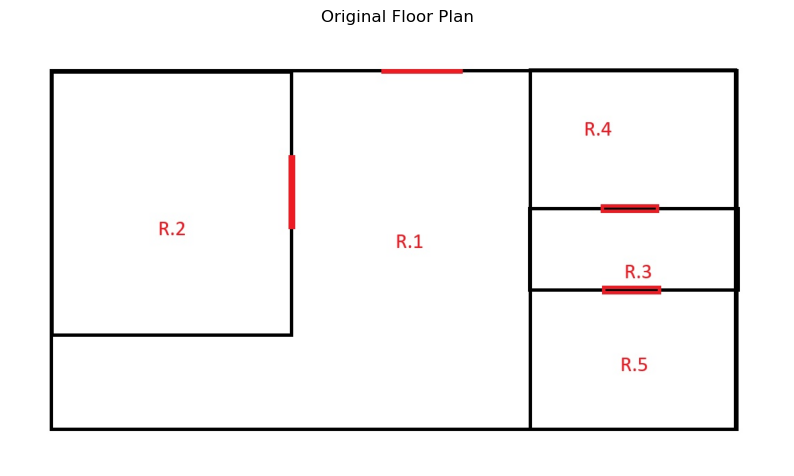

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Load the image
img = cv2.imread("data/floor_plan_3.jpg")  # adjust path
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(img_rgb)
plt.title("Original Floor Plan")
plt.axis("off")
plt.show()


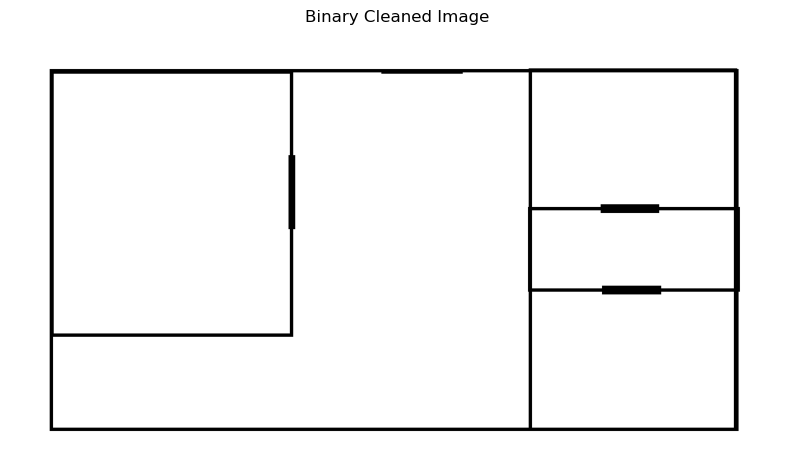

In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Otsu thresholding (auto adaptive)
_, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Ensure walls = white, background = black
# If inverted, use bitwise_not()
if np.mean(bw) < 127:
    bw = cv2.bitwise_not(bw)

# Clean up with morphology
kernel = np.ones((3, 3), np.uint8)
bw_clean = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel, iterations=2)
bw_clean = cv2.morphologyEx(bw_clean, cv2.MORPH_OPEN, kernel, iterations=1)

plt.figure(figsize=(10,10))
plt.imshow(bw_clean, cmap="gray")
plt.title("Binary Cleaned Image")
plt.axis("off")
plt.show()


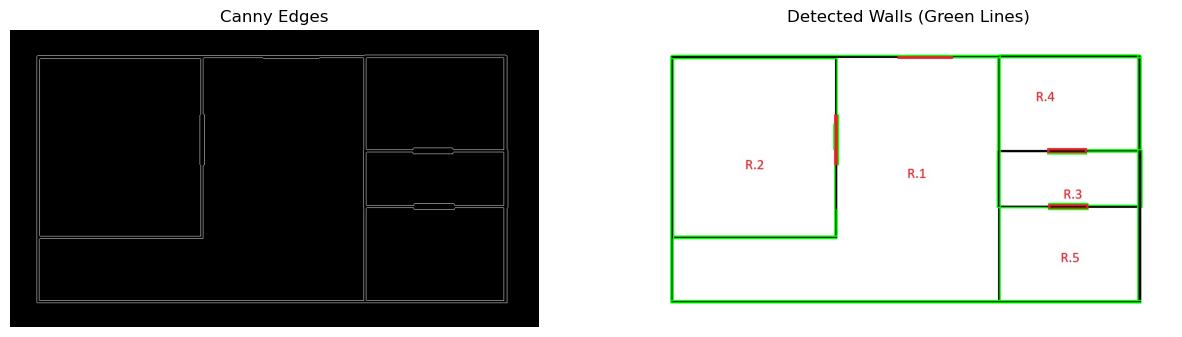

In [4]:
edges = cv2.Canny(bw_clean, 50, 150, apertureSize=3)

lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=80,
                        minLineLength=40, maxLineGap=8)

wall_vis = img_rgb.copy()
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(wall_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

fig, axs = plt.subplots(1, 2, figsize=(15,10))

axs[0].imshow(edges, cmap='gray')
axs[0].set_title("Canny Edges")
axs[0].axis("off")

axs[1].imshow(wall_vis)
axs[1].set_title("Detected Walls (Green Lines)")
axs[1].axis("off")

plt.show()




549912.0
60752.0
34521.0
136003.0
60154.0
233533.5


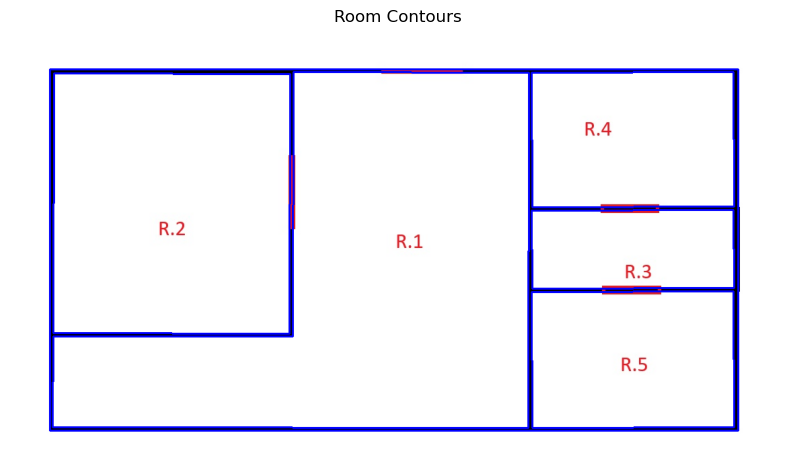

Detected 6 rooms.


In [5]:
# Invert image so rooms = white
inv = cv2.bitwise_not(bw_clean)

contours, hierarchy = cv2.findContours(inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

room_vis = img_rgb.copy()
rooms = []

for c in contours:
    area = cv2.contourArea(c)
    print(area)
    if area < 2000:   # ignore small specks
        continue
    perimeter = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * perimeter, True)
    x, y, w, h = cv2.boundingRect(approx)
    cv2.drawContours(room_vis, [approx], -1, (0,0,255), 2)
    rooms.append({
        "area": float(area),
        "bbox": [int(x), int(y), int(w), int(h)],
        "polygon": approx.squeeze().tolist()
    })

plt.figure(figsize=(10,10))
plt.imshow(room_vis)
plt.title("Room Contours")
plt.axis("off")
plt.show()

print(f"Detected {len(rooms)} rooms.")


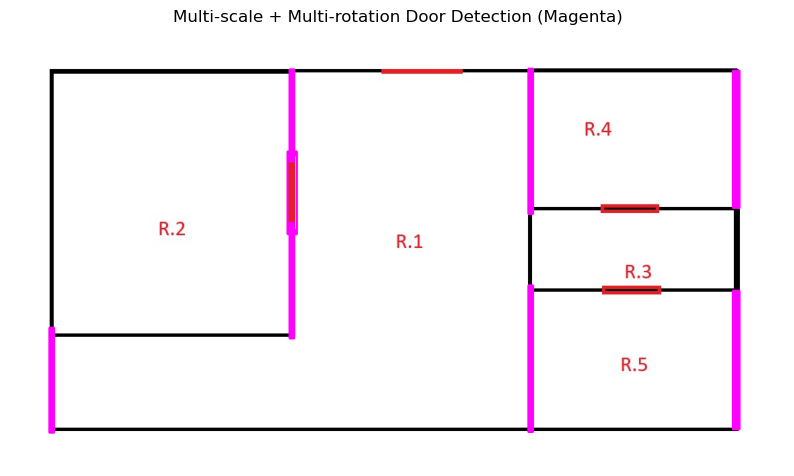

In [6]:
door_t = cv2.imread("data/door2.png", cv2.IMREAD_GRAYSCALE)
door_t = cv2.resize(door_t, None, fx=0.8, fy=0.8)

plan_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

scales = [0.5, 0.75, 1.0, 1.25]
rotations = [0, 90, 180, 270]
threshold = 0.9

door_vis = img_rgb.copy()
all_matches = []

for angle in rotations:
    # rotate template
    (h, w) = door_t.shape[:2]
    center = (w // 2, h // 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(door_t, rot_mat, (w, h), flags=cv2.INTER_LINEAR)

    for s in scales:
        temp = cv2.resize(rotated, None, fx=s, fy=s)
        res = cv2.matchTemplate(plan_gray, temp, cv2.TM_CCOEFF_NORMED)
        yy, xx = np.where(res > threshold)
        h2, w2 = temp.shape[:2]
        for (x, y) in zip(xx, yy):
            all_matches.append((x, y, w2, h2))

# draw rectangles for all matches
door_vis = img_rgb.copy()
for (x, y, w, h) in all_matches:
    cv2.rectangle(door_vis, (x, y), (x + w, y + h), (255, 0, 255), 2)

plt.figure(figsize=(10,10))
plt.imshow(door_vis)
plt.title("Multi-scale + Multi-rotation Door Detection (Magenta)")
plt.axis("off")
plt.show()


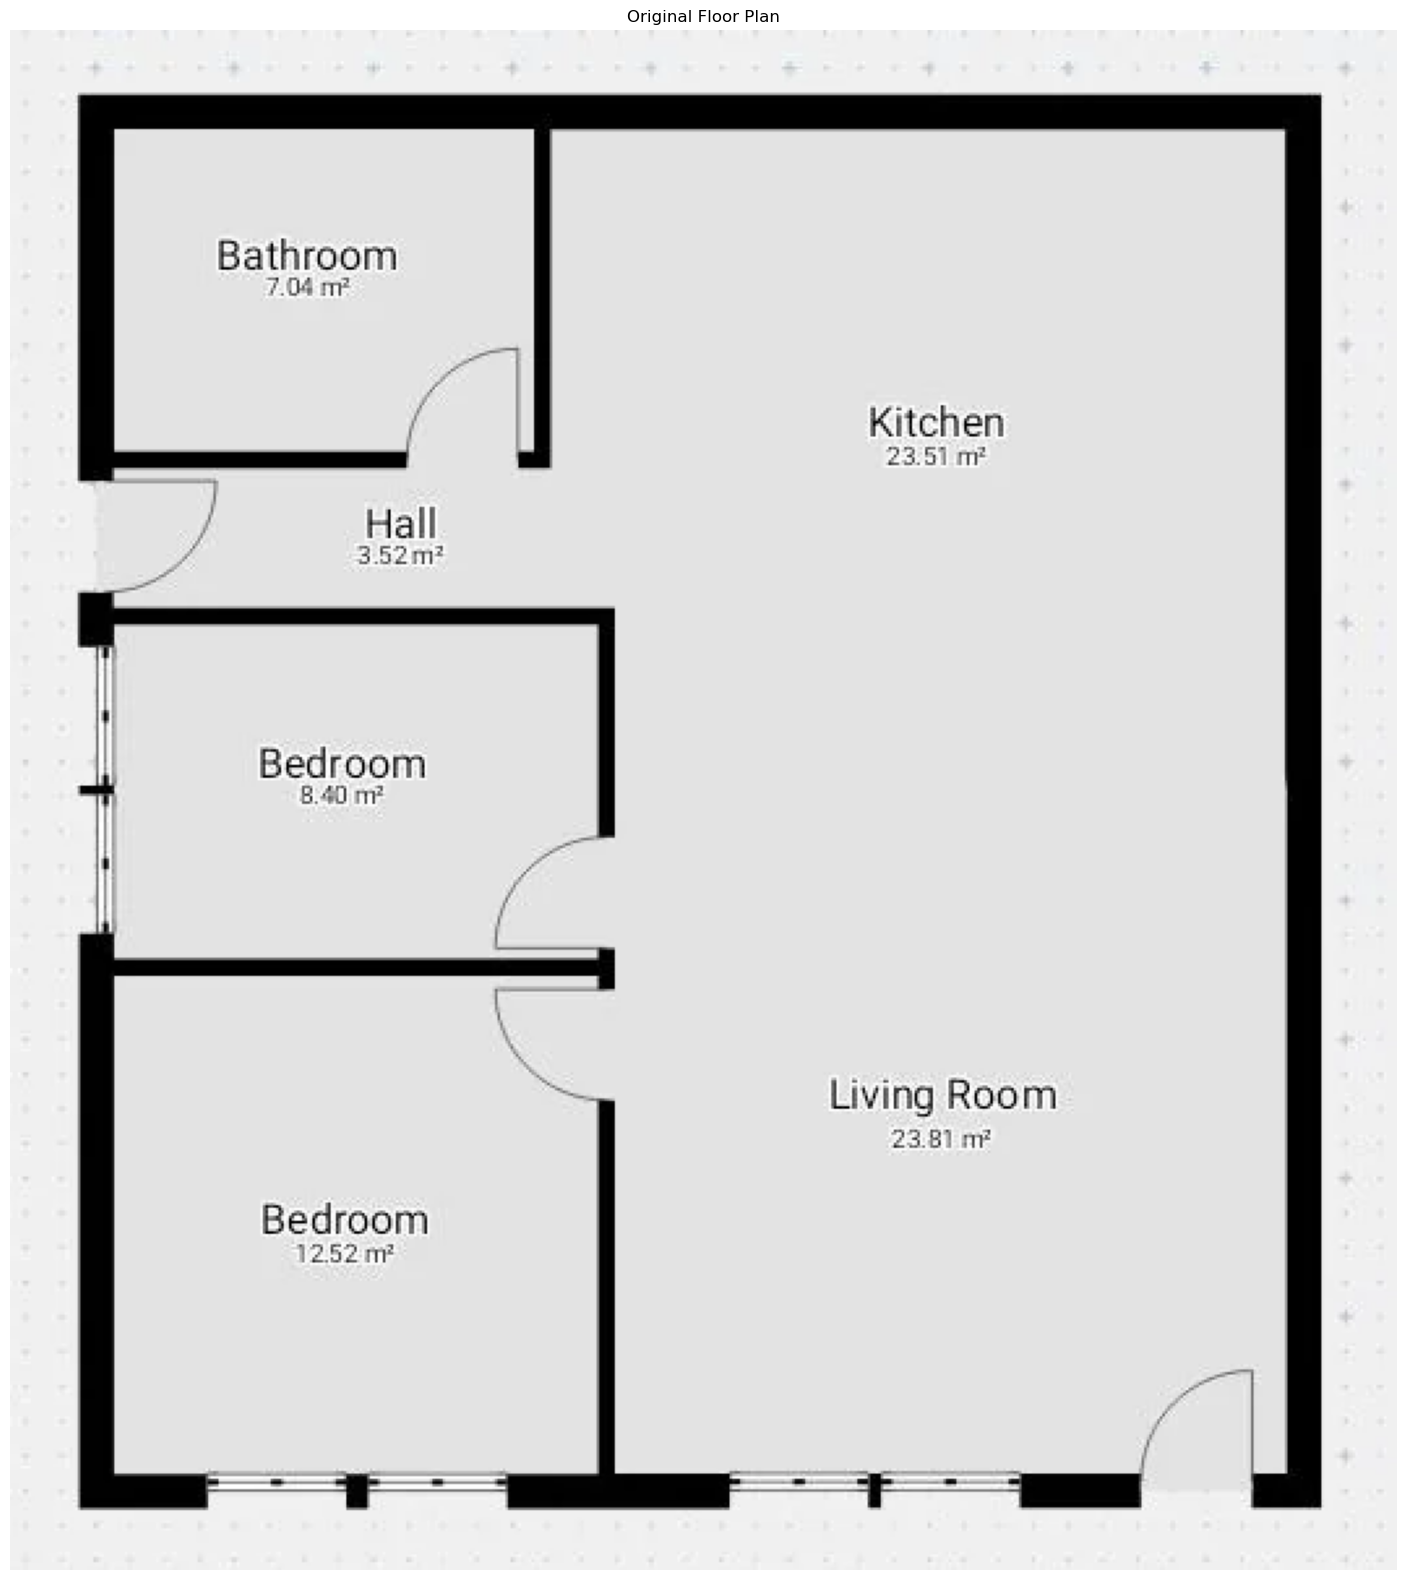

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Load the image
img = cv2.imread("data/simplefloorplan.png")  # adjust path
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,20))
plt.imshow(img_rgb)
plt.title("Original Floor Plan")
plt.axis("off")
plt.show()


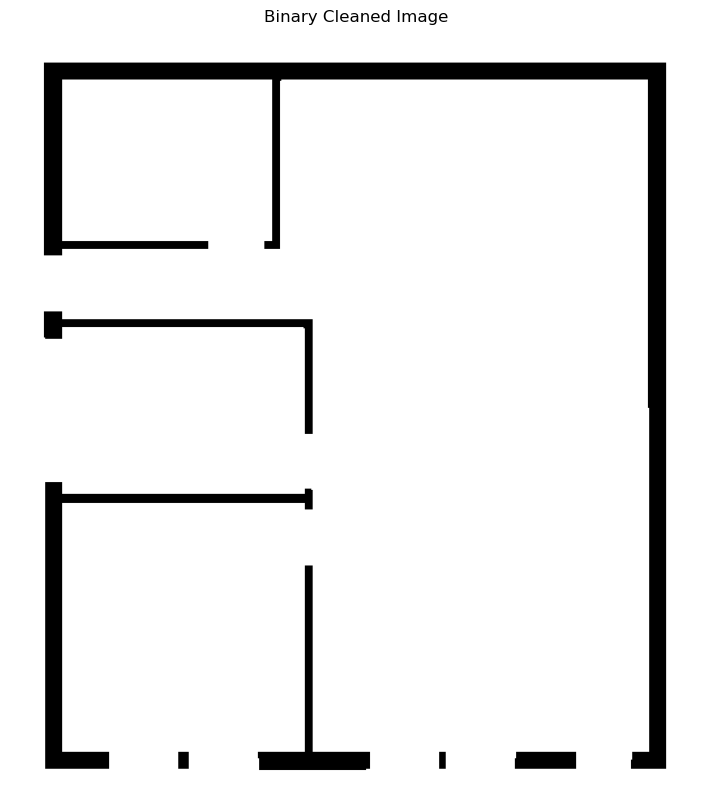

In [8]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Otsu thresholding (auto adaptive)
_, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Ensure walls = white, background = black
# If inverted, use bitwise_not()
if np.mean(bw) < 127:
    bw = cv2.bitwise_not(bw)

# Clean up with morphology
kernel = np.ones((3, 3), np.uint8)

bw_clean = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel, iterations=2)
bw_clean = cv2.morphologyEx(bw_clean, cv2.MORPH_OPEN, kernel, iterations=1)

plt.figure(figsize=(10,10))
plt.imshow(bw_clean, cmap="gray")
plt.title("Binary Cleaned Image")
plt.axis("off")
plt.show()


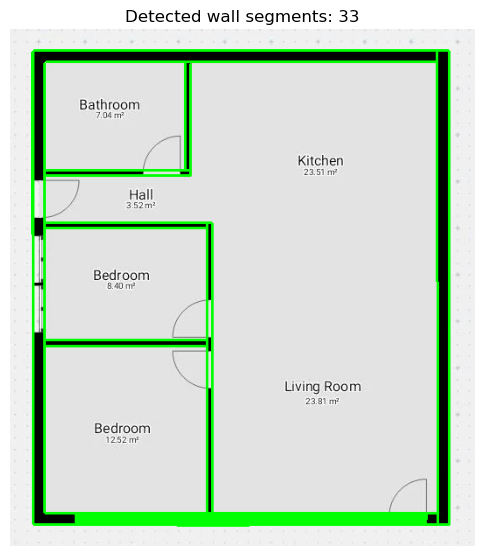

In [9]:
edges = cv2.Canny(bw_clean, 50, 150, apertureSize=3)

# --- Wall detection using Probabilistic Hough Transform ---

lines = cv2.HoughLinesP(
    edges,
    rho=1,                        # distance resolution in pixels
    theta=np.pi/180,              # angle resolution in radians (~1°)
    threshold=5,                 # votes required to form a line
    minLineLength=60,             # minimum wall length (px)
    maxLineGap=150                  # max gap between segments to link them
)

# --- Visualize results ---
wall_vis = img_rgb.copy()

if lines is not None:
    for (x1, y1, x2, y2) in lines[:, 0, :]:
        cv2.line(wall_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.figure(figsize=(6, 8))
plt.imshow(wall_vis)
plt.title(f"Detected wall segments: {0 if lines is None else len(lines)}")
plt.axis("off")
plt.show()





547.5
48.0
84.0
1810.0
4259.0
1632.5
15475.5


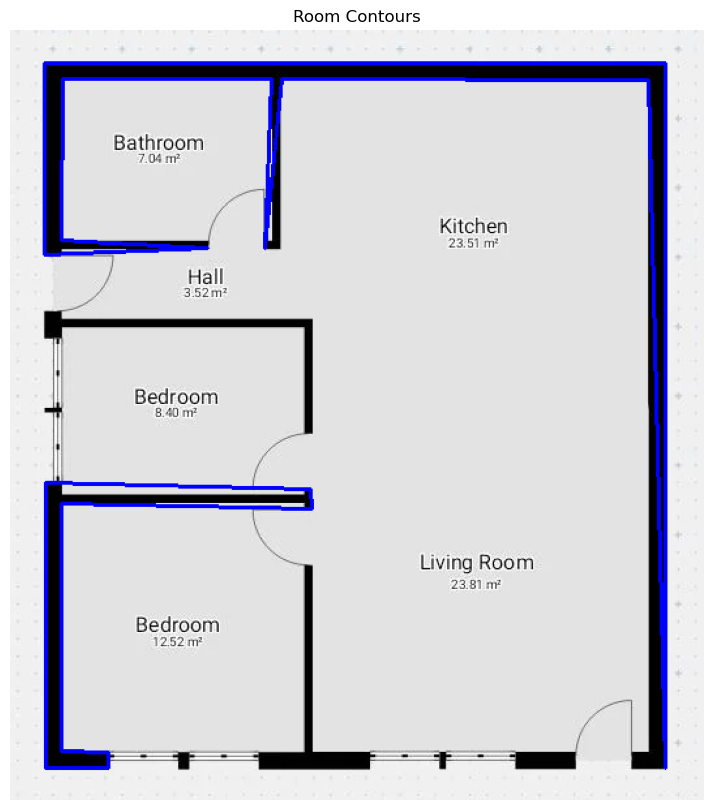

Detected 2 rooms.


In [10]:
# Invert image so rooms = white
inv = cv2.bitwise_not(bw_clean)

contours, hierarchy = cv2.findContours(inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

room_vis = img_rgb.copy()
rooms = []

for c in contours:
    area = cv2.contourArea(c)
    print(area)
    if area < 2000:   # ignore small specks
        continue
    perimeter = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.01 * perimeter, True)
    x, y, w, h = cv2.boundingRect(approx)
    cv2.drawContours(room_vis, [approx], -1, (0,0,255), 2)
    rooms.append({
        "area": float(area),
        "bbox": [int(x), int(y), int(w), int(h)],
        "polygon": approx.squeeze().tolist()
    })

plt.figure(figsize=(10,10))
plt.imshow(room_vis)
plt.title("Room Contours")
plt.axis("off")
plt.show()

print(f"Detected {len(rooms)} rooms.")


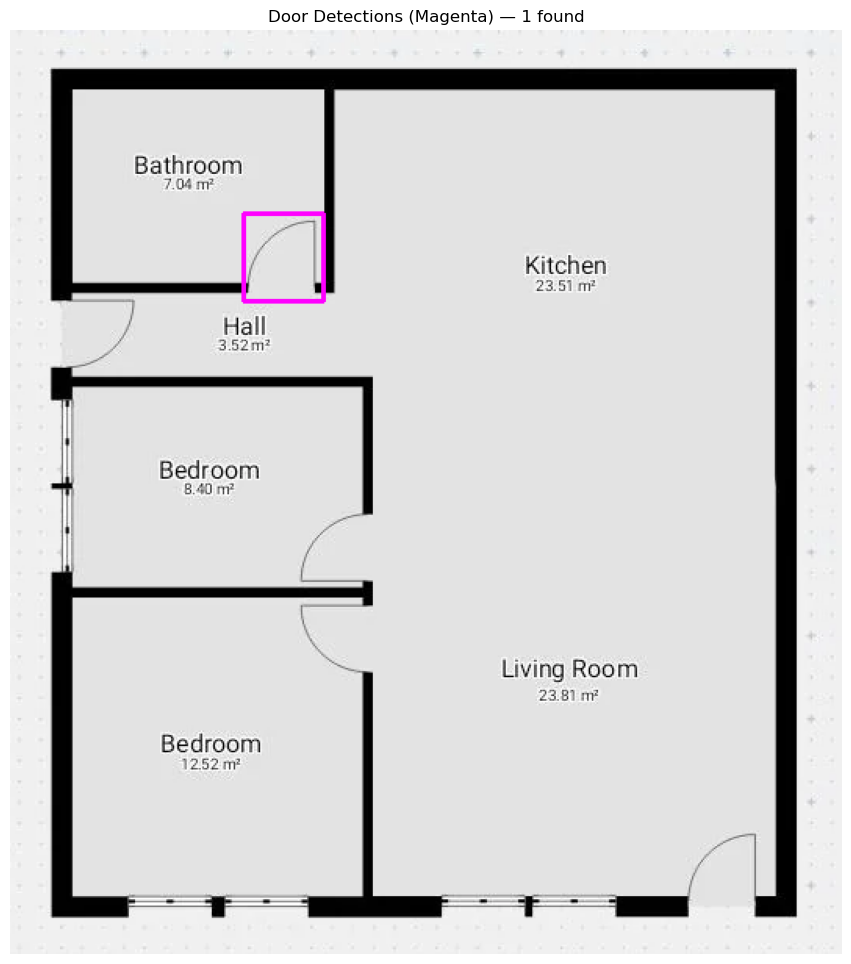

In [11]:
# --- Step 1: Read images ---
plan_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
door_t = cv2.imread("data/door_temp.png", cv2.IMREAD_GRAYSCALE)

# --- Step 2: Multi-scale, multi-orientation matching ---
scales = [0.5, 0.75, 1.0, 1.25]
rotations = [0, 90, 180, 270]
threshold = .85  # matching confidence

door_vis = img_rgb.copy()
all_matches = []

for angle in rotations:
    # rotate template
    (h, w) = door_t.shape[:2]
    center = (w // 2, h // 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(door_t, rot_mat, (w, h), flags=cv2.INTER_LINEAR)

    for s in scales:
        temp = cv2.resize(rotated, None, fx=s, fy=s)
        res = cv2.matchTemplate(plan_gray, temp, cv2.TM_CCOEFF_NORMED)
        yy, xx = np.where(res >= threshold)

        h2, w2 = temp.shape[:2]
        for (x, y) in zip(xx, yy):
            all_matches.append((x, y, w2, h2))

# --- Step 3: Draw detections ---
for (x, y, w, h) in all_matches:
    cv2.rectangle(door_vis, (x, y), (x + w, y + h), (255, 0, 255), 2)

plt.figure(figsize=(12, 12))
plt.imshow(door_vis)
plt.title(f"Door Detections (Magenta) — {len(all_matches)} found")
plt.axis("off")
plt.show()


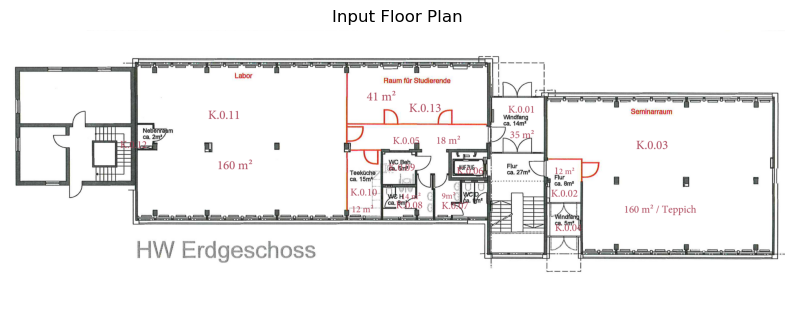

In [12]:
img = cv2.imread("data/floor_plan_cropped.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(10,10))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Input Floor Plan")
plt.show()


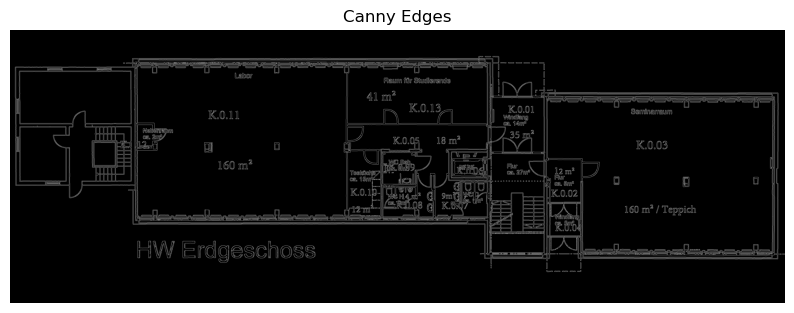

In [13]:
blur = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blur, 50, 150)

plt.figure(figsize=(10,10))
plt.imshow(edges, cmap="gray")
plt.axis("off")
plt.title("Canny Edges")
plt.show()


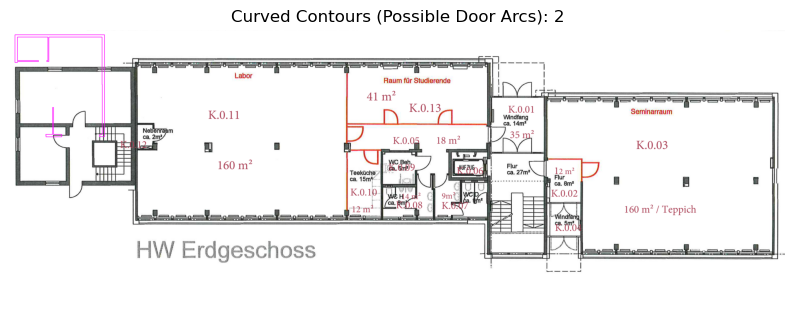

In [14]:
arc_candidates = []
vis = img_rgb.copy()

for c in contours:
    area = cv2.contourArea(c)
    if area < 200:        # ignore tiny noise
        continue

    perimeter = cv2.arcLength(c, True)

    # Approximate contour
    approx = cv2.approxPolyDP(c, 0.02 * perimeter, True)

    # Curved objects have many points but low polygonal simplification
    if len(approx) > 6 and perimeter > 100:
        arc_candidates.append(c)
        cv2.drawContours(vis, [c], -1, (255, 0, 255), 2)

plt.figure(figsize=(10,10))
plt.imshow(vis)
plt.axis("off")
plt.title(f"Curved Contours (Possible Door Arcs): {len(arc_candidates)}")
plt.show()


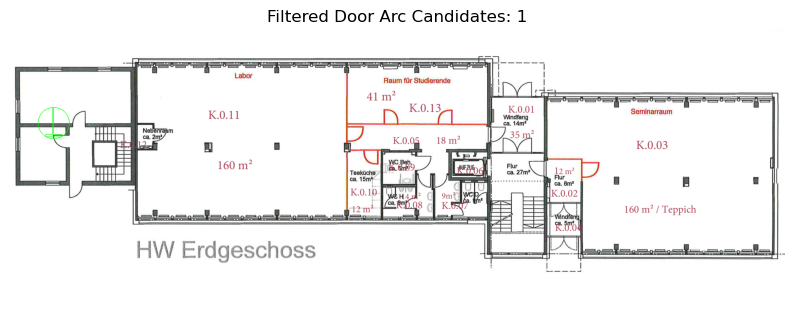

In [15]:
final_arcs = []
vis2 = img_rgb.copy()

for c in arc_candidates:
    (x, y), radius = cv2.minEnclosingCircle(c)

    if 20 < radius < 150:  # adjust to your plan scale
        final_arcs.append(c)
        cv2.circle(vis2, (int(x), int(y)), int(radius), (0, 255, 0), 2)
        cv2.drawContours(vis2, [c], -1, (0, 255, 0), 2)

plt.figure(figsize=(10,10))
plt.imshow(vis2)
plt.axis("off")
plt.title(f"Filtered Door Arc Candidates: {len(final_arcs)}")
plt.show()


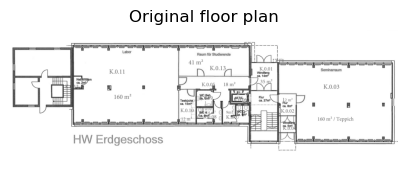

In [16]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("data/floor_plan_cropped.png", cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(5, 5))
plt.imshow(img, cmap="gray")
plt.title("Original floor plan")
plt.axis("off")
plt.show()


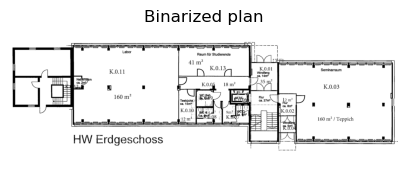

In [17]:
_, bw = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.figure(figsize=(5, 5))
plt.imshow(bw, cmap="gray")
plt.title("Binarized plan")
plt.axis("off")
plt.show()


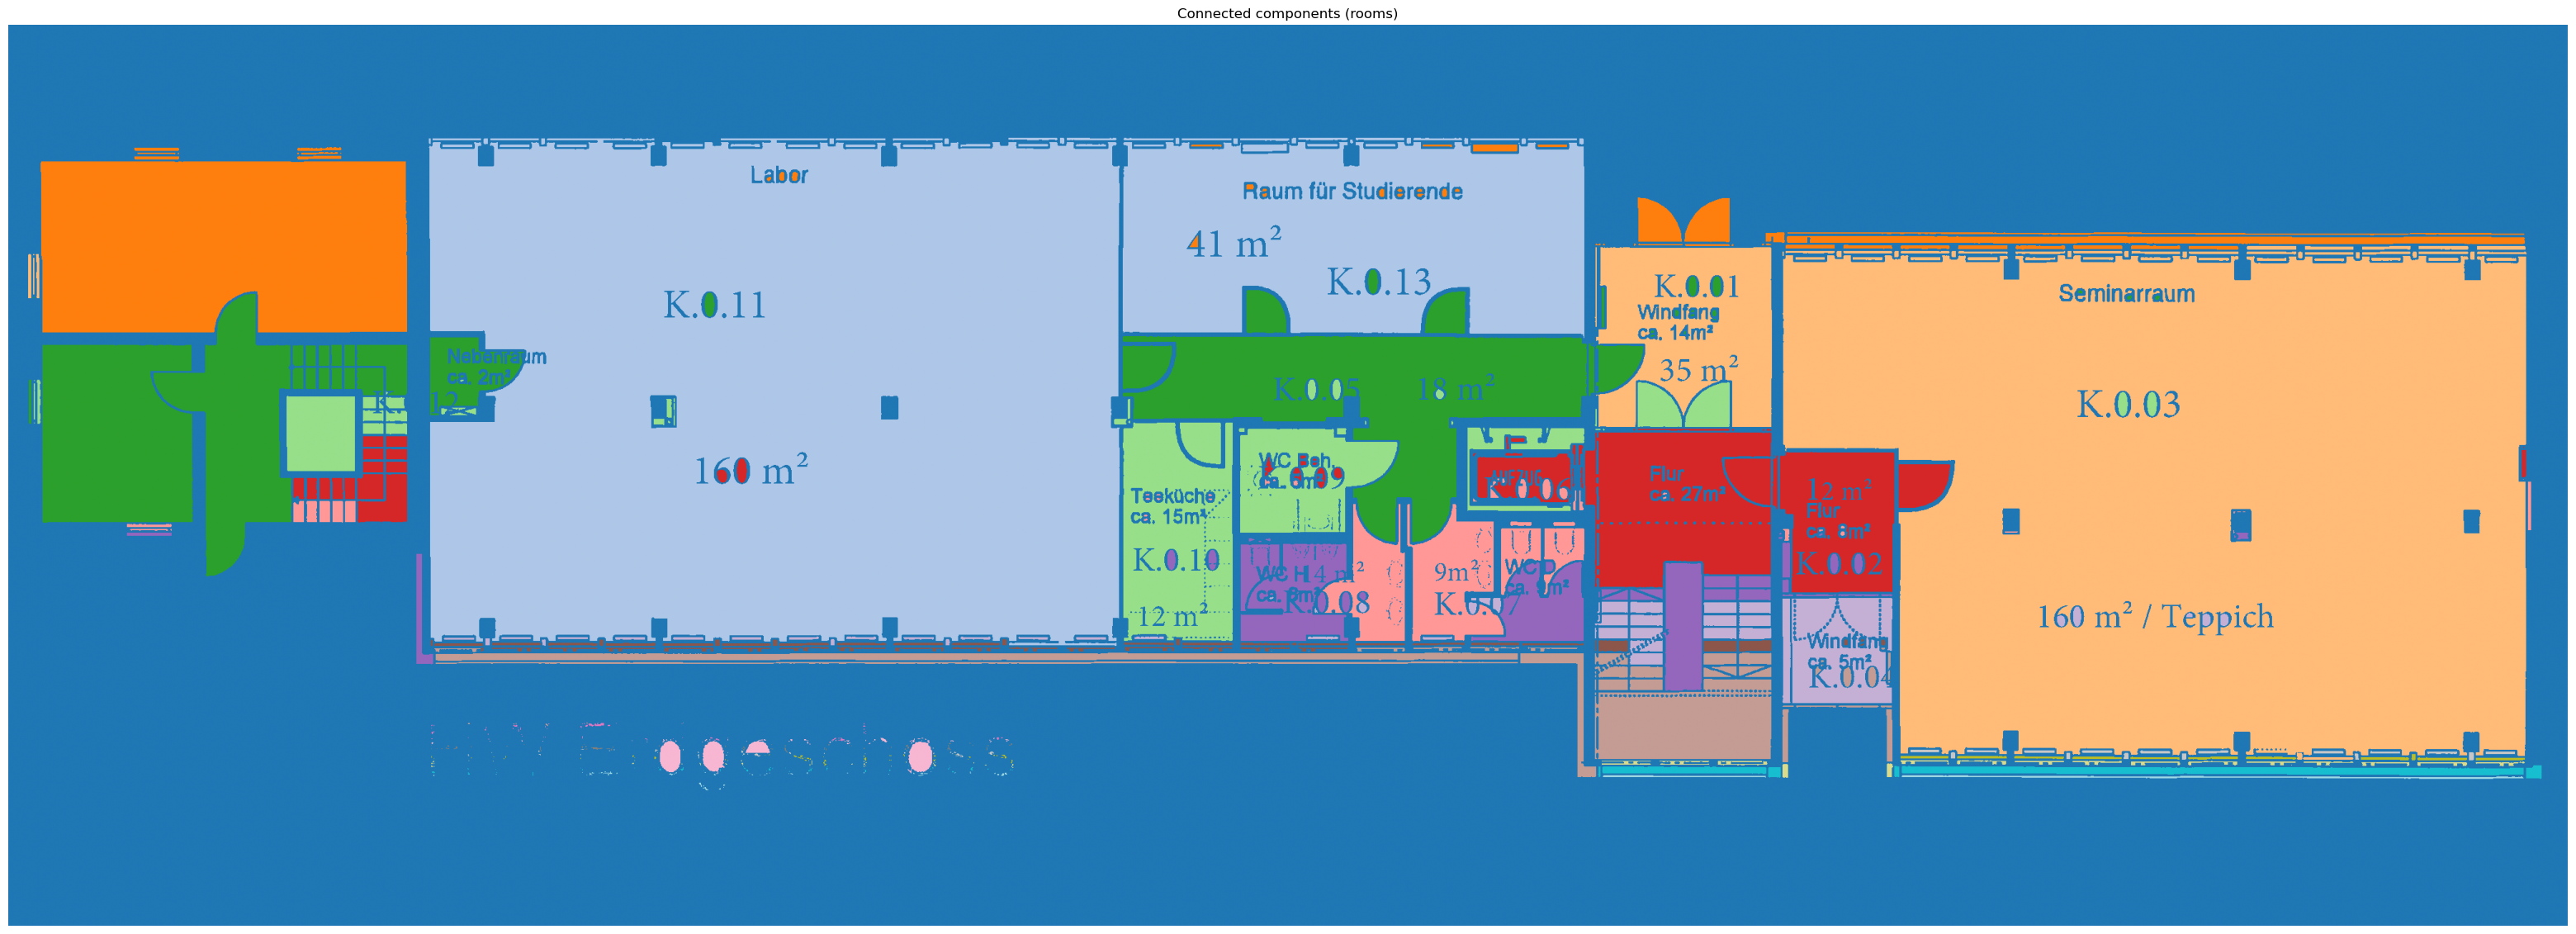

In [18]:
# Use connectedComponentsWithStats instead of connectedComponents
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
    bw, connectivity=8, ltype=cv2.CV_32S
)


plt.figure(figsize=(40, 30))
plt.imshow(labels, cmap="tab20")
plt.title("Connected components (rooms)")
plt.axis("off")
plt.show()


In [19]:
print("num_labels:", num_labels)        # how many components (incl. background)
print("labels shape:", labels.shape)    # same HxW as the image
print("stats shape:", stats.shape)      # one row per label
print("centroids shape:", centroids.shape)


num_labels: 981
labels shape: (1450, 4120)
stats shape: (981, 5)
centroids shape: (981, 2)


In [20]:
for label in range(1, num_labels):  # skip 0 = background
    x = stats[label, cv2.CC_STAT_LEFT]
    y = stats[label, cv2.CC_STAT_TOP]
    w = stats[label, cv2.CC_STAT_WIDTH]
    h = stats[label, cv2.CC_STAT_HEIGHT]
    area = stats[label, cv2.CC_STAT_AREA]
    cx, cy = centroids[label]

    #print(f"Label {label}: bbox=({x},{y},{w},{h}), area={area}, centroid=({cx:.1f},{cy:.1f})")


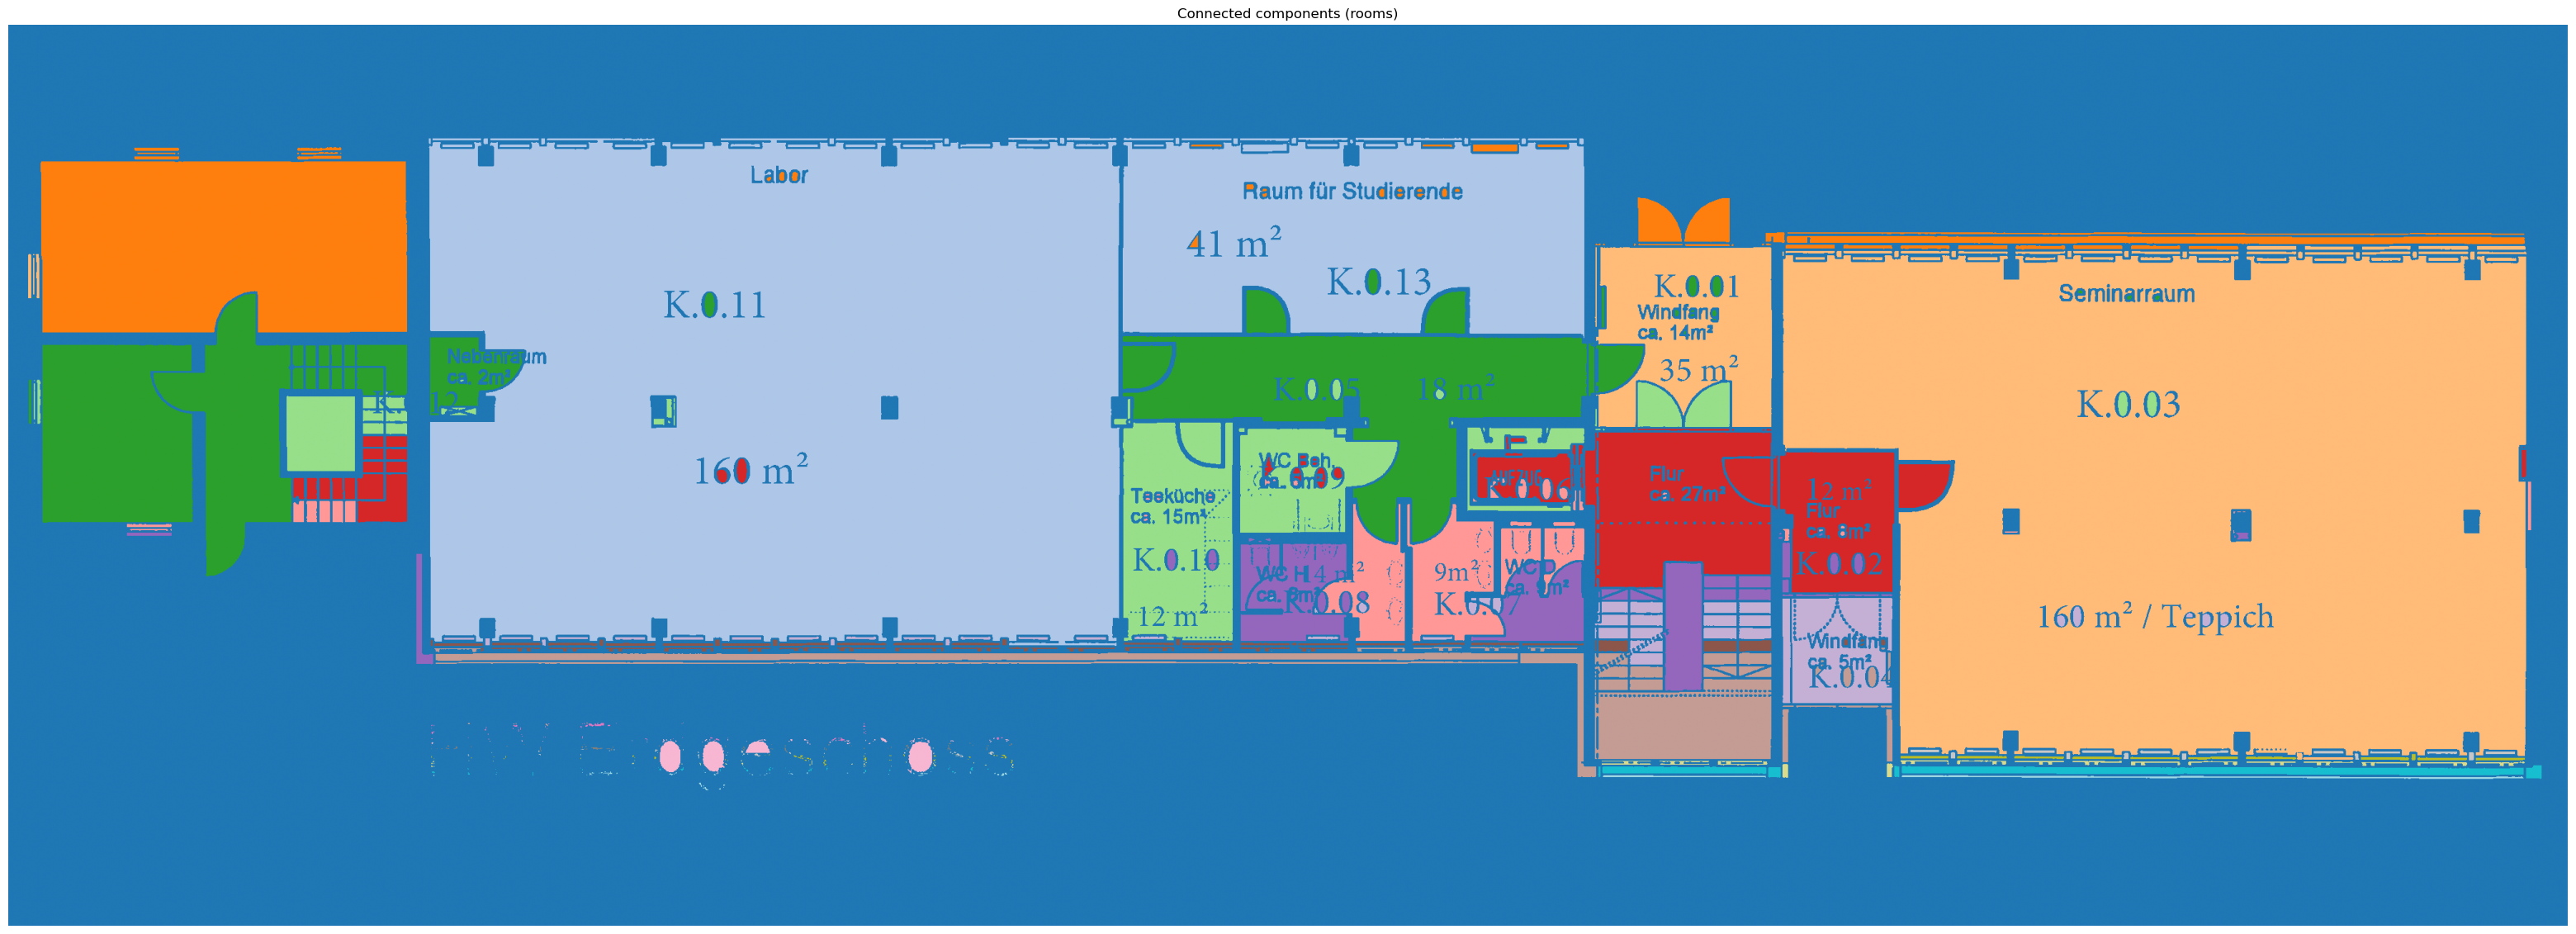

In [21]:
plt.figure(figsize=(40, 30))
plt.imshow(labels, cmap="tab20")
plt.title("Connected components (rooms)")
plt.axis("off")
plt.show()


In [22]:
min_area = 1500  # tune this for your image scale

rooms = []
for label in range(1, num_labels):
    x = stats[label, cv2.CC_STAT_LEFT]
    y = stats[label, cv2.CC_STAT_TOP]
    w = stats[label, cv2.CC_STAT_WIDTH]
    h = stats[label, cv2.CC_STAT_HEIGHT]
    area = stats[label, cv2.CC_STAT_AREA]
    cx, cy = centroids[label]

    if area < min_area:
        continue  # skip noise

    rooms.append({
        "label": label,
        "bbox": (x, y, w, h),
        "area": area,
        "centroid": (cx, cy),
    })

print("Detected rooms:", len(rooms))


Detected rooms: 57


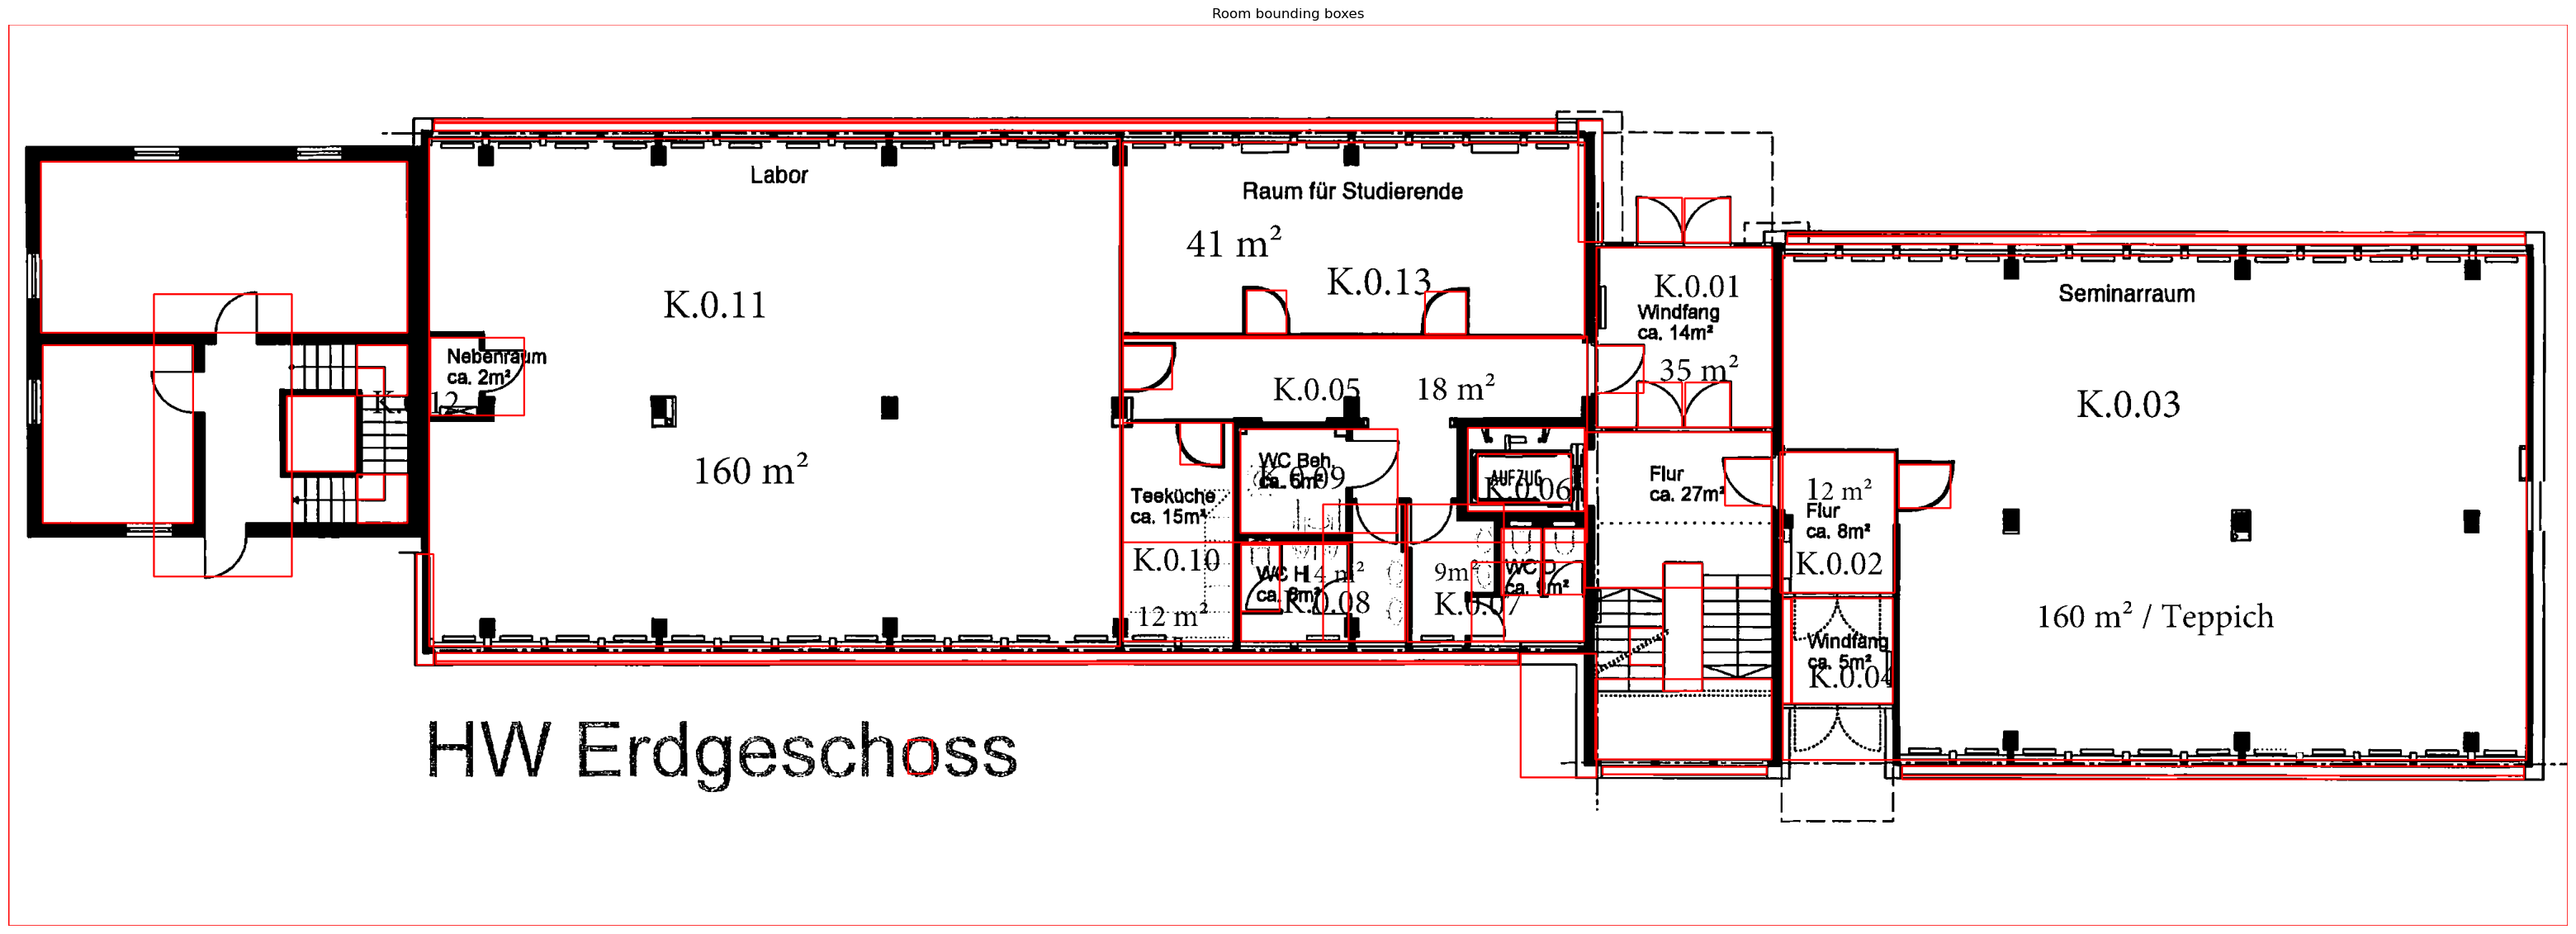

In [23]:
vis = cv2.cvtColor(bw, cv2.COLOR_GRAY2BGR)

for r in rooms:
    x, y, w, h = r["bbox"]
    cv2.rectangle(vis, (x, y), (x+w, y+h), (0, 0, 255), 2)

plt.figure(figsize=(40, 30))
plt.imshow(vis[..., ::-1])  # BGR->RGB
plt.axis("off")
plt.title("Room bounding boxes")
plt.show()


In [24]:
# starting from your grayscale 'img'
_, wall_bw = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
# optional: close small gaps to get continuous walls
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
walls = cv2.morphologyEx(wall_bw, cv2.MORPH_CLOSE, kernel)


In [25]:
# Stronger closing to "seal" doors/windows
big_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
closed = cv2.morphologyEx(walls, cv2.MORPH_CLOSE, big_kernel)

# Difference between strongly-closed walls and original walls ~ potential openings
openings = cv2.subtract(closed, walls)


In [26]:
num_d, labels_d, stats_d, centroids_d = cv2.connectedComponentsWithStats(
    openings, connectivity=8, ltype=cv2.CV_32S
)

door_candidates = []
for i in range(1, num_d):
    area = stats_d[i, cv2.CC_STAT_AREA]
    if 50 < area < 2000:  # tune thresholds
        door_candidates.append(i)

print("door candidates:", len(door_candidates))


door candidates: 602


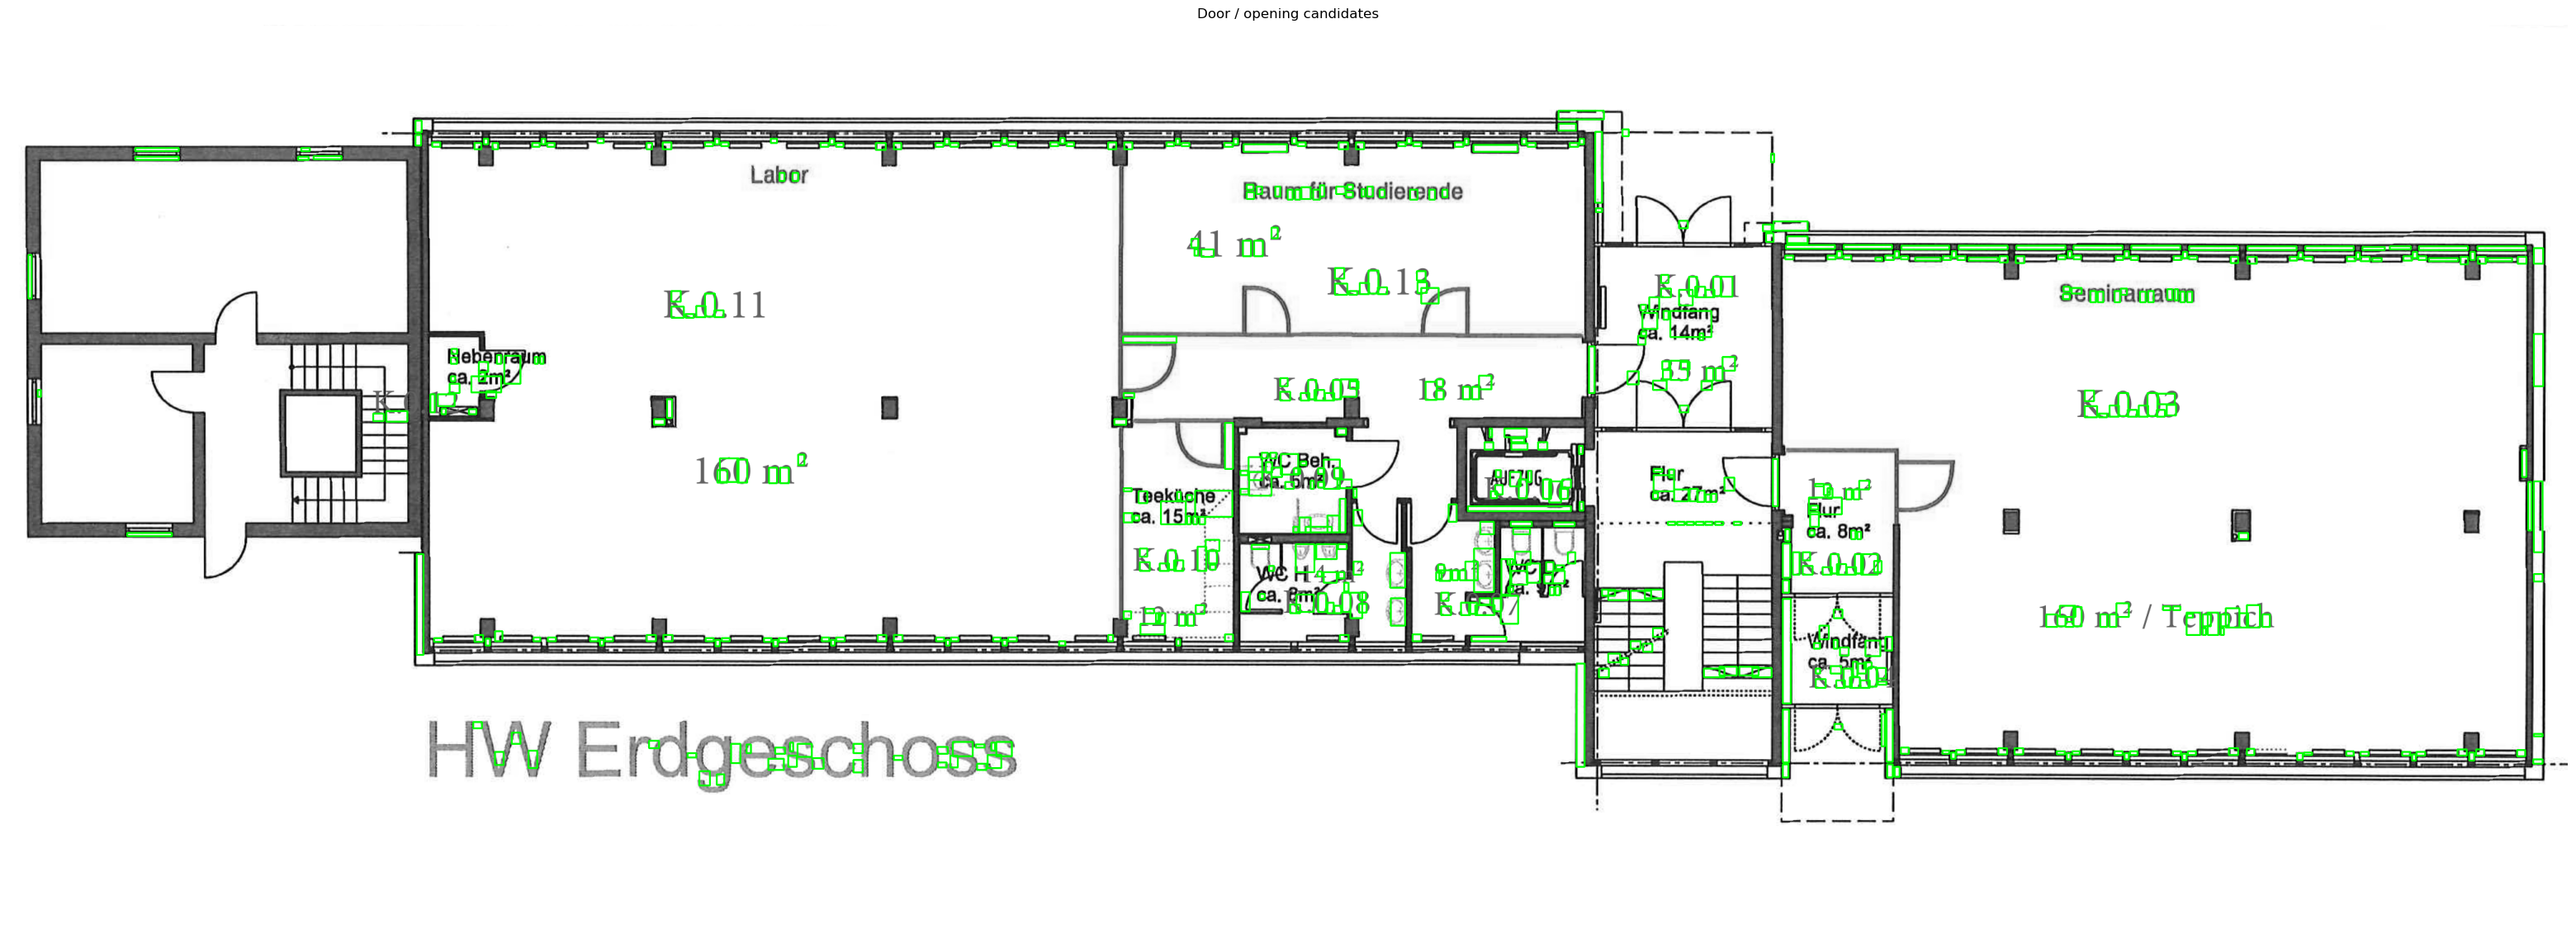

In [27]:
vis_doors = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
for i in door_candidates:
    x = stats_d[i, cv2.CC_STAT_LEFT]
    y = stats_d[i, cv2.CC_STAT_TOP]
    w = stats_d[i, cv2.CC_STAT_WIDTH]
    h = stats_d[i, cv2.CC_STAT_HEIGHT]
    cv2.rectangle(vis_doors, (x, y), (x+w, y+h), (0, 255, 0), 2)

plt.figure(figsize=(40, 30))
plt.imshow(vis_doors[..., ::-1])
plt.axis("off")
plt.title("Door / opening candidates")
plt.show()


In [28]:
%matplotlib tk


In [29]:
from pdf2image import convert_from_path
import matplotlib.pyplot as plt

# Convert PDF page to image (temporary)
pages = convert_from_path("data/k.0.11.pdf", dpi=300)
img = pages[0]

# # Show image
# fig, ax = plt.subplots(figsize=(12, 12))
# ax.imshow(img)
# ax.set_title("Click top-left and bottom-right corners to get crop box")

# # Click points interactively
# coords = plt.ginput(2)  # click twice on the figure
# plt.close(fig)

# print("Selected coordinates (x,y):", coords)


In [30]:
from pdf2image import convert_from_path
from PIL import Image

# Define your crop box in PDF units (left, top, right, bottom)
# You can find these coordinates using a PDF viewer or trial & e/rror
crop_box = (230.0538451252736, 1050.3894181751323, 4350.0592438449585, 2500.3377876949305)

pages = convert_from_path(
    "data/k.0.11.pdf",
    dpi=400,        # high-resolution render (vector precision)
    fmt='png'
)

# Crop first page directly in memory
cropped = pages[0].crop(crop_box)
# cropped.save("data/floor_plan_cropped.png")
cropped.show()


In [31]:

import matplotlib.pyplot as plt
import cv2

# Load the cropped image
img = cv2.imread("data/floor_plan_cropped.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,20))
plt.imshow(img_rgb)
plt.title("Cropped Floor Plan - Original")
plt.axis("off")
plt.show()

print(f"Image shape: {img.shape}")


Image shape: (1450, 4120, 3)


In [32]:
import numpy as np

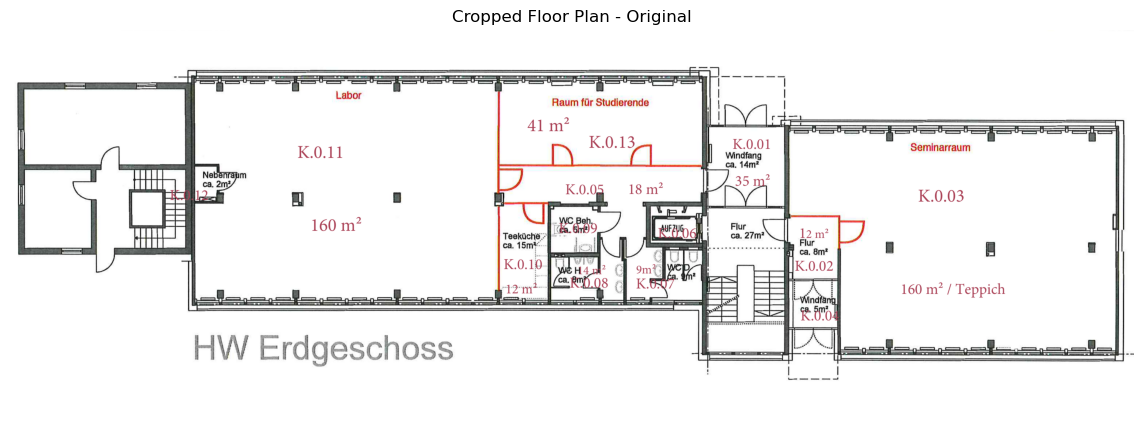

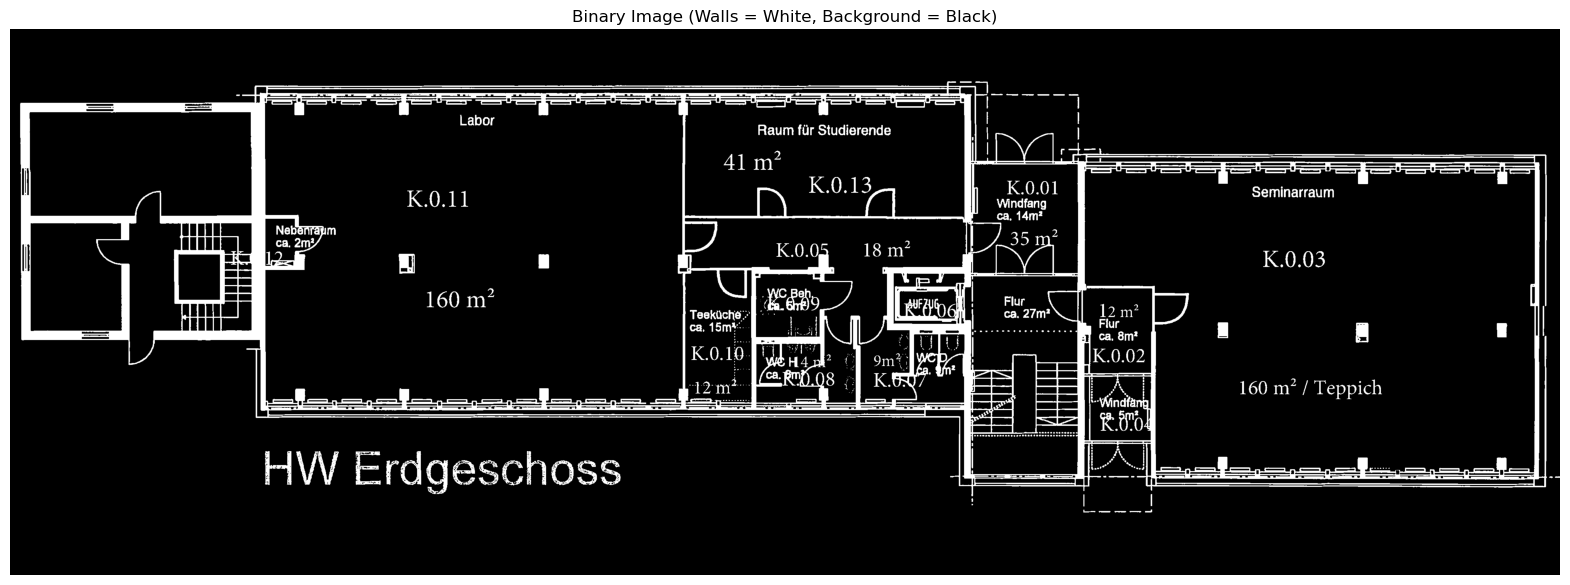

In [33]:
# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
%matplotlib inline

# Apply Otsu's thresholding to binarize automatically
_, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Invert if background is white (so walls are white on black background)
if np.mean(bw) > 127:
    bw = cv2.bitwise_not(bw)

plt.figure(figsize=(20,20))
plt.imshow(bw, cmap='gray')
plt.title("Binary Image (Walls = White, Background = Black)")
plt.axis("off")
plt.show()


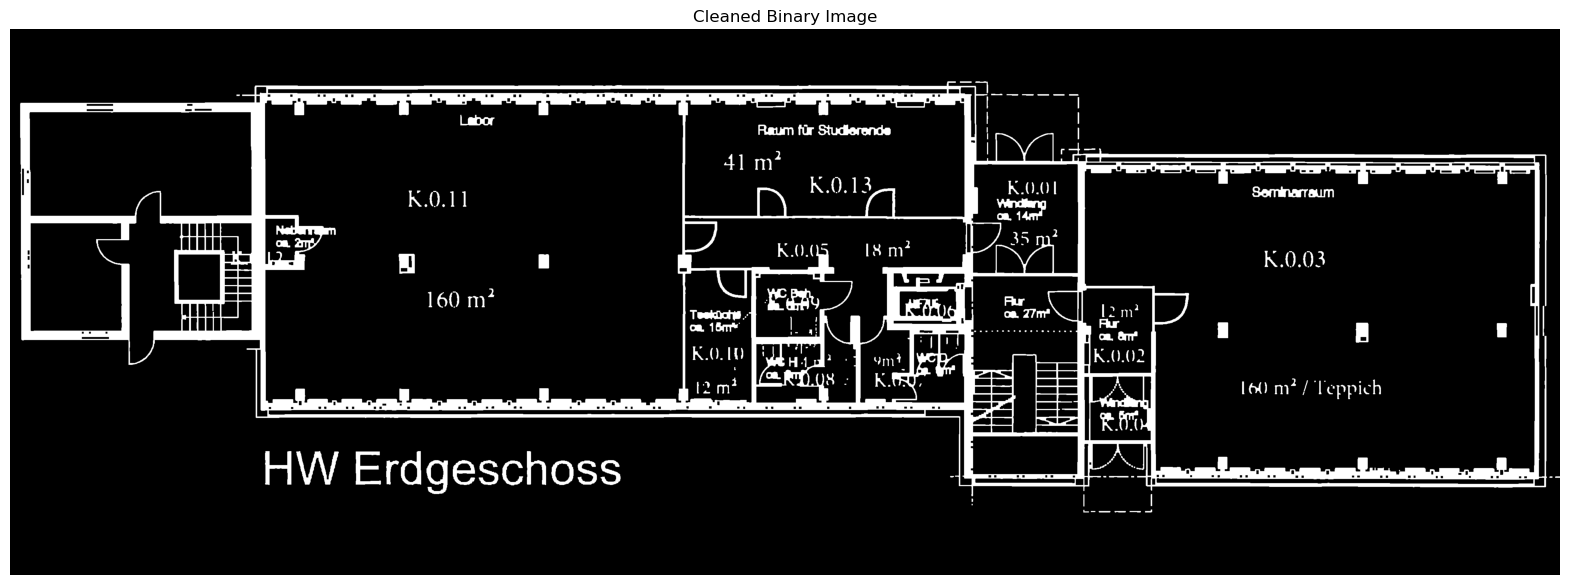

In [34]:
import numpy as np
%matplotlib inline
kernel = np.ones((3,3), np.uint8)
bw_clean = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel, iterations=2)
bw_clean = cv2.morphologyEx(bw_clean, cv2.MORPH_OPEN, kernel, iterations=1)

plt.figure(figsize=(20,20))
plt.imshow(bw_clean, cmap='gray')
plt.title("Cleaned Binary Image")
plt.axis("off")
plt.show()


In [35]:
cv2.imwrite("data/floor_plan_11_cleaned.png", bw)


True

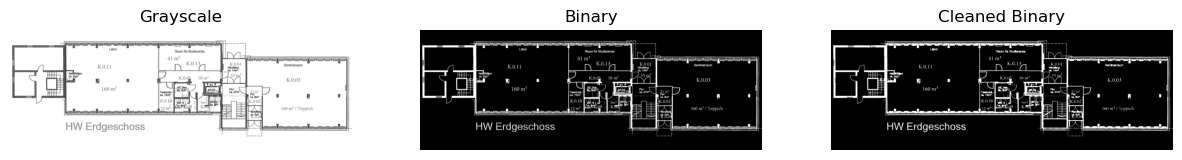

In [36]:
%matplotlib inline
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(gray, cmap='gray'); axs[0].set_title("Grayscale"); axs[0].axis("off")
axs[1].imshow(bw, cmap='gray'); axs[1].set_title("Binary"); axs[1].axis("off")
axs[2].imshow(bw_clean, cmap='gray'); axs[2].set_title("Cleaned Binary"); axs[2].axis("off")
plt.show()


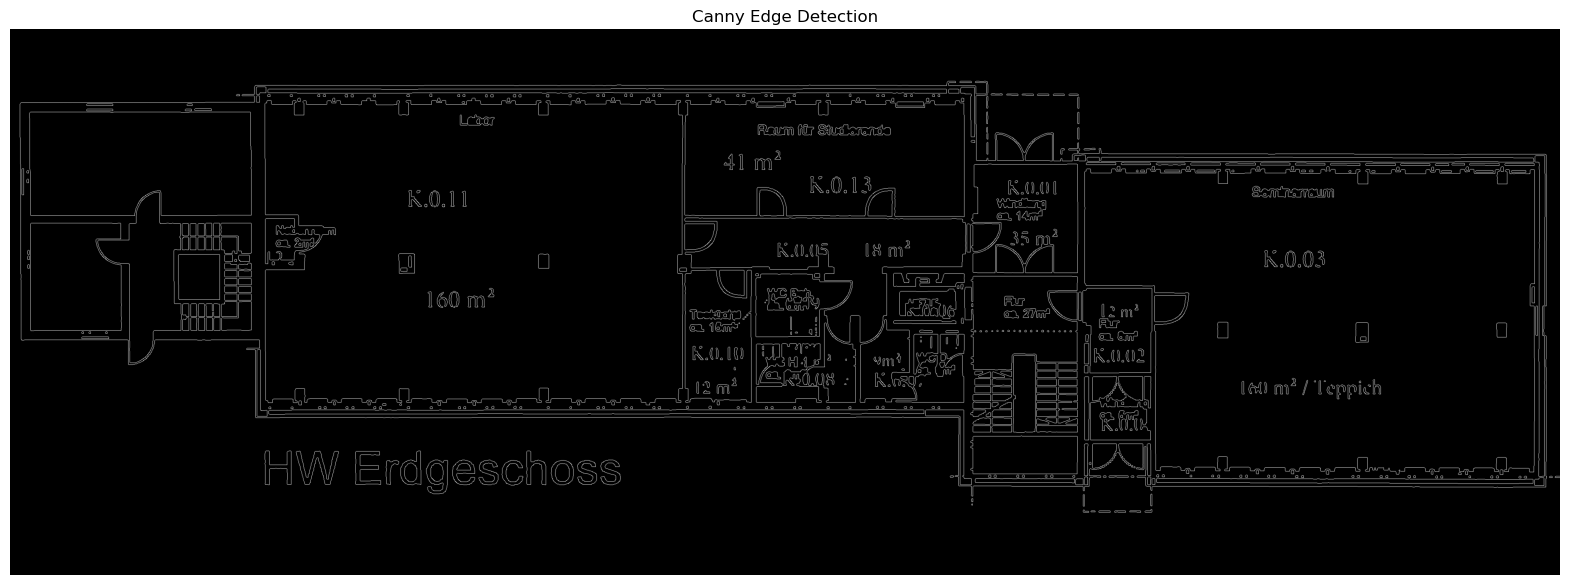

Edge pixel count: 111537


In [37]:
# Apply Canny Edge Detection
edges = cv2.Canny(bw_clean, threshold1=50, threshold2=150, apertureSize=3)

plt.figure(figsize=(20,20))
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis("off")
plt.show()

print("Edge pixel count:", np.count_nonzero(edges))


In [38]:
cv2.imwrite("data/K_11_edges.png", edges)


True

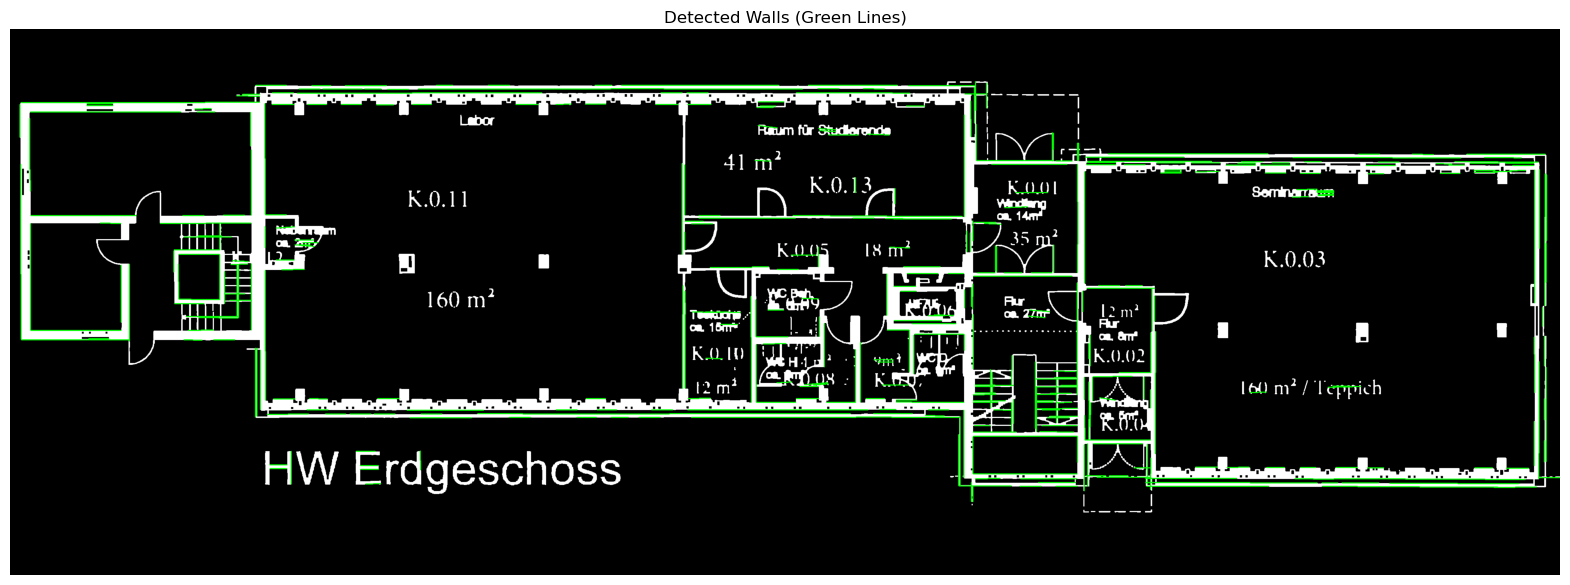

Total lines detected: 449


In [39]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Detect lines using Probabilistic Hough Transform
lines = cv2.HoughLinesP(edges, 
                        rho=1, 
                        theta=np.pi/180, 
                        threshold=80, 
                        minLineLength=40, 
                        maxLineGap=8)

# Copy original for visualization
walls_vis = cv2.cvtColor(bw_clean, cv2.COLOR_GRAY2BGR)

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(walls_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(walls_vis, cv2.COLOR_BGR2RGB))
plt.title("Detected Walls (Green Lines)")
plt.axis("off")
plt.show()

print(f"Total lines detected: {len(lines)}")


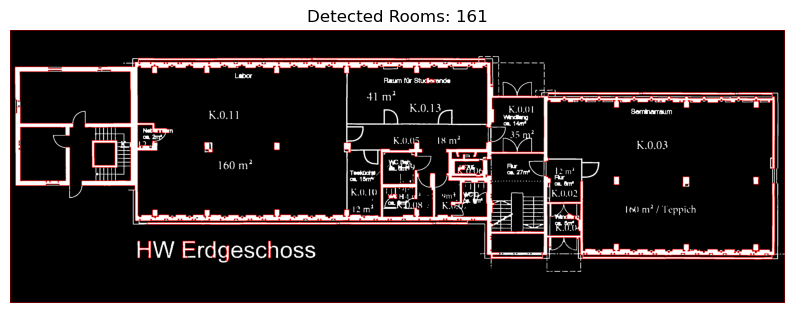

In [40]:
# Invert + connect walls
inv = cv2.bitwise_not(bw_clean)
kernel = np.ones((5,5), np.uint8)
closed = cv2.morphologyEx(inv, cv2.MORPH_CLOSE, kernel, iterations=2)
%matplotlib inline
# Find contours
contours, hierarchy = cv2.findContours(closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

room_vis = cv2.cvtColor(bw_clean, cv2.COLOR_GRAY2BGR)
for c in contours:
    area = cv2.contourArea(c)
    if area < 800:  # reduced threshold
        continue
    cv2.drawContours(room_vis, [c], -1, (0,0,255), 2)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(room_vis, cv2.COLOR_BGR2RGB))
plt.title(f"Detected Rooms: {len(contours)}")
plt.axis("off")
plt.show()


In [41]:
valid_rooms = []
areas = [cv2.contourArea(c) for c in contours]
avg_area = np.mean(areas)

for c in contours:
    area = cv2.contourArea(c)
    if area < 0.05 * avg_area or area > 0.8 * np.max(areas):
        continue
    valid_rooms.append(c)

print(f"Filtered by area: {len(valid_rooms)} rooms left.")


Filtered by area: 15 rooms left.


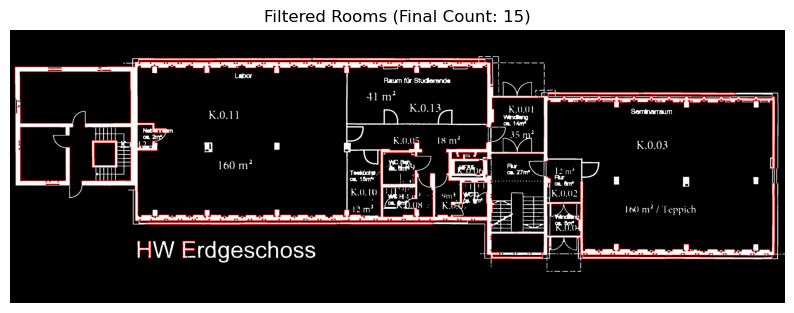

In [42]:
room_vis = cv2.cvtColor(bw_clean, cv2.COLOR_GRAY2BGR)
for c in valid_rooms:
    cv2.drawContours(room_vis, [c], -1, (0,0,255), 2)
%matplotlib inline
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(room_vis, cv2.COLOR_BGR2RGB))
plt.title(f"Filtered Rooms (Final Count: {len(valid_rooms)})")
plt.axis("off")
plt.show()

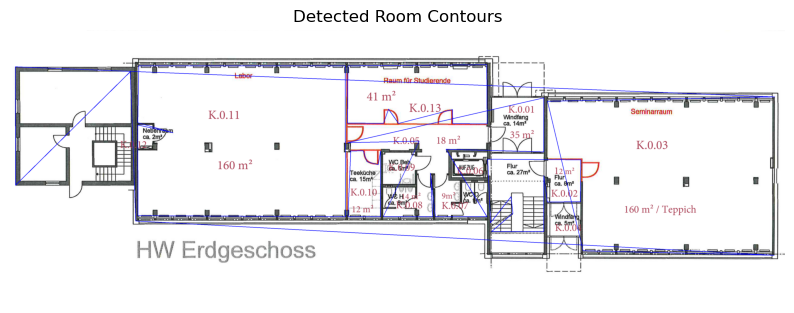

Detected 6 rooms.


In [43]:
# Step 1: Invert clean binary
inv = cv2.bitwise_not(bw_clean)
%matplotlib inline
# Step 2: Optional - Close tiny wall gaps
kernel = np.ones((3,3), np.uint8)
inv = cv2.morphologyEx(inv, cv2.MORPH_CLOSE, kernel, iterations=2)

# Step 3: Find all contours (hierarchical)
contours, hierarchy = cv2.findContours(inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

room_vis = img_rgb.copy()
rooms = []

for i, c in enumerate(contours):
    area = cv2.contourArea(c)
    if area < 50000:
        continue

    perimeter = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * perimeter, True)
    x, y, w, h = cv2.boundingRect(approx)

    # Ignore outermost contour (building outline)
    if hierarchy[0][i][3] == -1:
        continue

    cv2.drawContours(room_vis, [approx], -1, (0, 0, 255), 2)
    rooms.append({
        "area": float(area),
        "bbox": [int(x), int(y), int(w), int(h)],
        "polygon": approx.squeeze().tolist()
    })

plt.figure(figsize=(10,10))
plt.imshow(room_vis)
plt.title("Detected Room Contours")
plt.axis("off")
plt.show()

print(f"Detected {len(rooms)} rooms.")


In [44]:
%pip install pdf2image

Note: you may need to restart the kernel to use updated packages.


In [45]:
%pip install shapely

Note: you may need to restart the kernel to use updated packages.


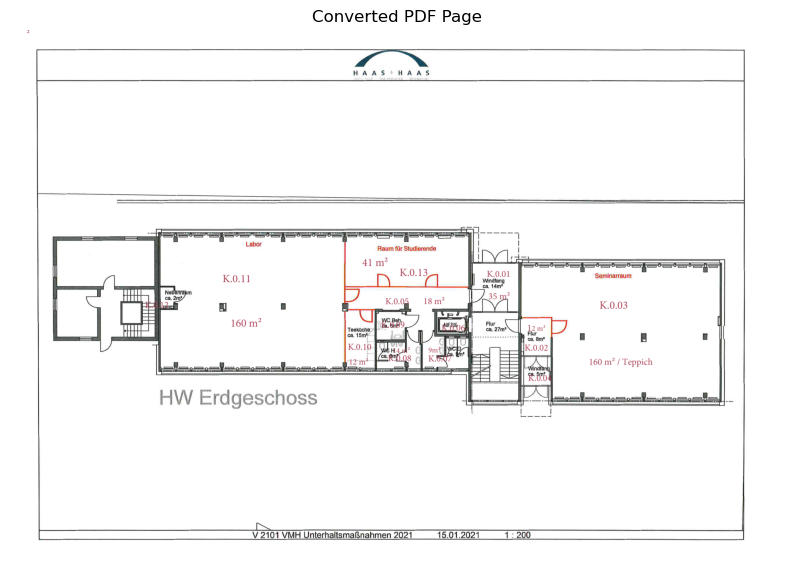

In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
%matplotlib inline
# 1. Convert PDF page to a PIL image
pages = convert_from_path("data/K.0.11.pdf", dpi=300) # Higher DPI = better quality
first_page = pages[0]

# 2. Convert PIL image to NumPy array (OpenCV format)
# Note: pdf2image returns RGB, so we convert it to BGR for OpenCV consistency, 
# or just leave it as RGB for Matplotlib
img_rgb = np.array(first_page)
img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

# 3. Now you can proceed with your grayscale and thresholding
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
_, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Displaying in the notebook
plt.figure(figsize=(10,10))
plt.imshow(img_rgb) # Matplotlib expects RGB
plt.title("Converted PDF Page")
plt.axis("off")
plt.show()

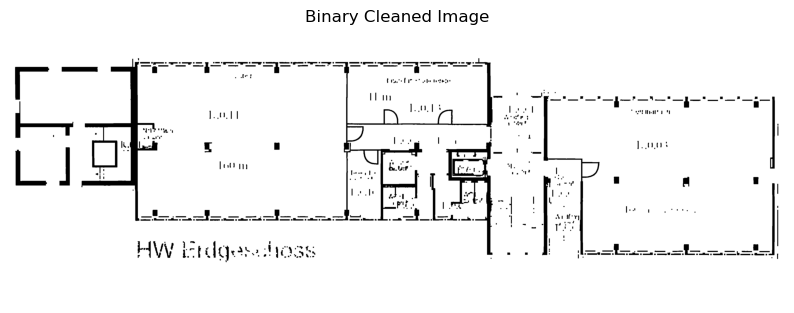

In [47]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
%matplotlib inline
# Otsu thresholding (auto adaptive)
_, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Ensure walls = white, background = black
# If inverted, use bitwise_not()
if np.mean(bw) < 127:
    bw = cv2.bitwise_not(bw)

# Clean up with morphology
kernel = np.ones((3, 3), np.uint8)
bw_clean = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel, iterations=2)
bw_clean = cv2.morphologyEx(bw_clean, cv2.MORPH_OPEN, kernel, iterations=1)

plt.figure(figsize=(10,10))
plt.imshow(bw_clean, cmap="gray")
plt.title("Binary Cleaned Image")
plt.axis("off")
plt.show()


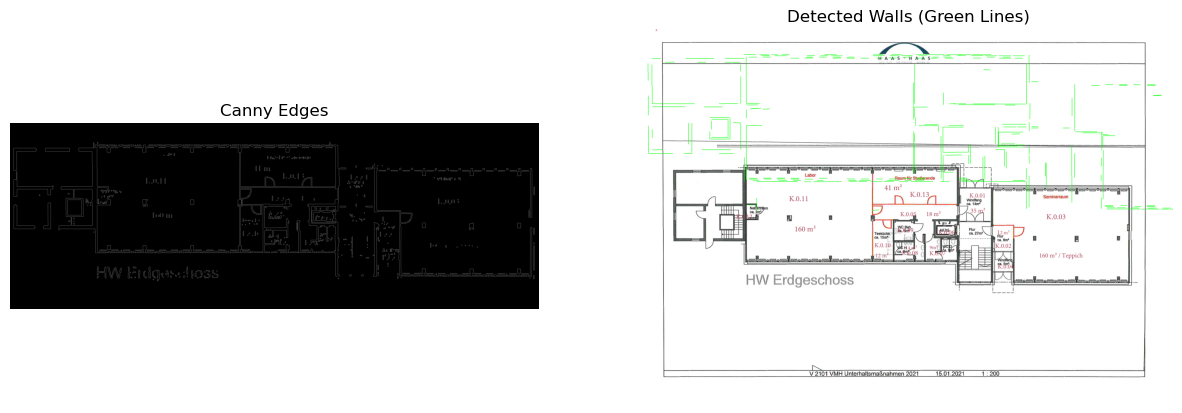

In [48]:
edges = cv2.Canny(bw_clean, 50, 150, apertureSize=3)
%matplotlib inline
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=80,
                        minLineLength=40, maxLineGap=8)

wall_vis = img_rgb.copy()
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(wall_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

fig, axs = plt.subplots(1, 2, figsize=(15,10))

axs[0].imshow(edges, cmap='gray')
axs[0].set_title("Canny Edges")
axs[0].axis("off")

axs[1].imshow(wall_vis)
axs[1].set_title("Detected Walls (Green Lines)")
axs[1].axis("off")

plt.show()




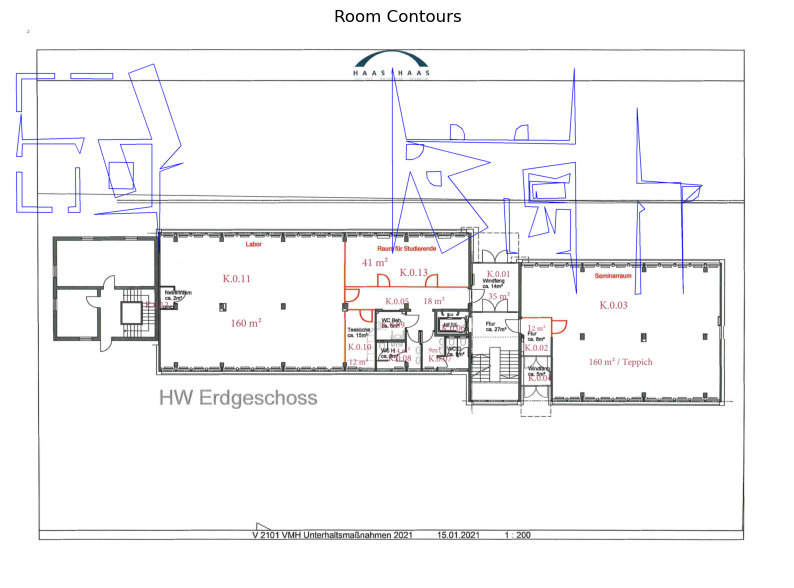

Detected 21 rooms.


In [49]:
# Invert image so rooms = white
inv = cv2.bitwise_not(bw_clean)
%matplotlib inline
contours, hierarchy = cv2.findContours(inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

room_vis = img_rgb.copy()
rooms = []

for c in contours:
    area = cv2.contourArea(c)
    #print(area)
    if area < 2000:   # ignore small specks
        continue
    perimeter = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * perimeter, True)
    x, y, w, h = cv2.boundingRect(approx)
    cv2.drawContours(room_vis, [approx], -1, (0,0,255), 2)
    rooms.append({
        "area": float(area),
        "bbox": [int(x), int(y), int(w), int(h)],
        "polygon": approx.squeeze().tolist()
    })

plt.figure(figsize=(10,10))
plt.imshow(room_vis)
plt.title("Room Contours")
plt.axis("off")
plt.show()

print(f"Detected {len(rooms)} rooms.")


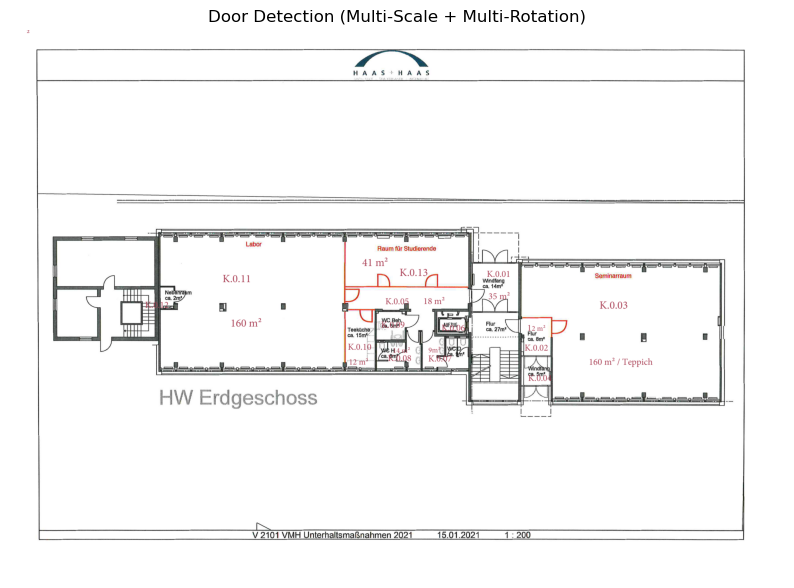

Detected 0 possible door locations.


In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the base door template (grayscale)
door_t = cv2.imread("data/door_k_11_1.png", cv2.IMREAD_GRAYSCALE)
door_t = cv2.resize(door_t, None, fx=0.8, fy=0.8)

# Convert floor plan to grayscale
plan_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

# Rotations (0°, 90°, 180°, 270°)
rotations = [
    ("0°", door_t),
    ("90°", cv2.rotate(door_t, cv2.ROTATE_90_CLOCKWISE)),
    ("180°", cv2.rotate(door_t, cv2.ROTATE_180)),
    ("270°", cv2.rotate(door_t, cv2.ROTATE_90_COUNTERCLOCKWISE)),
]

# Scales to test
scales = [0.5, 0.75, 1.0, 1.25]

# Collect all matches
all_matches = []

# Loop through each rotation + scale
for angle, rot_temp in rotations:
    for s in scales:
        temp = cv2.resize(rot_temp, None, fx=s, fy=s)
        res = cv2.matchTemplate(plan_gray, temp, cv2.TM_CCOEFF_NORMED)
        yy, xx = np.where(res > 0.7)  # adjust threshold
        h, w = temp.shape[:2]
        for (x, y) in zip(xx, yy):
            all_matches.append((x, y, w, h, angle, s))

# Draw detections
door_vis = img_rgb.copy()
for (x, y, w, h, angle, s) in all_matches:
    cv2.rectangle(door_vis, (x, y), (x+w, y+h), (255, 0, 255), 2)
    cv2.putText(door_vis, f"{angle}", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 255), 1)

plt.figure(figsize=(10,10))
plt.imshow(door_vis)
plt.title("Door Detection (Multi-Scale + Multi-Rotation)")
plt.axis("off")
plt.show()

print(f"Detected {len(all_matches)} possible door locations.")


Raw matches before NMS: 0
Matches after NMS: 0


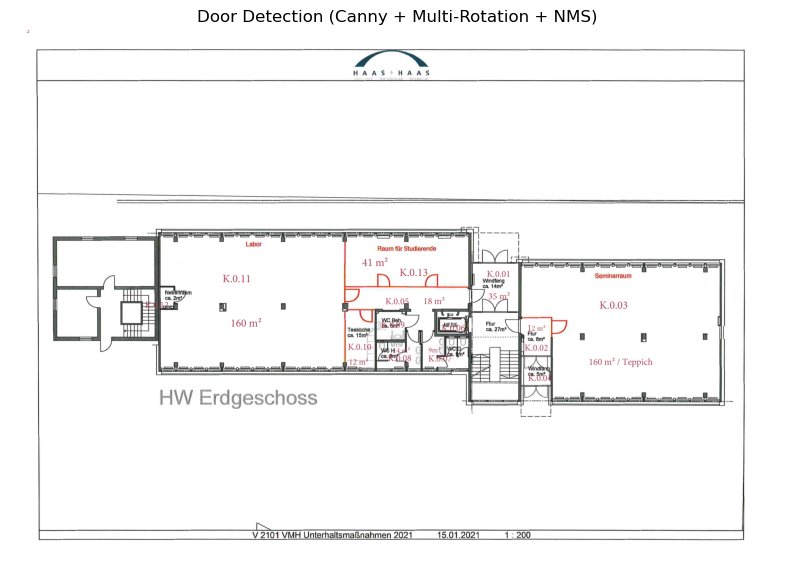

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ---- Step 1: Load and preprocess template ----
door_t = cv2.imread("data/door_k_11_1.png", cv2.IMREAD_GRAYSCALE)
door_t = cv2.resize(door_t, None, fx=0.8, fy=0.8)

# Convert template to edges
door_edges = cv2.Canny(door_t, 50, 150)

# ---- Step 2: Convert floor plan to grayscale and edges ----
plan_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
plan_edges = cv2.Canny(plan_gray, 50, 150)

# ---- Step 3: Define rotations and scales ----
rotations = [
    ("0°", door_edges),
    ("90°", cv2.rotate(door_edges, cv2.ROTATE_90_CLOCKWISE)),
    ("180°", cv2.rotate(door_edges, cv2.ROTATE_180)),
    ("270°", cv2.rotate(door_edges, cv2.ROTATE_90_COUNTERCLOCKWISE)),
]
scales = [0.5, 0.75, 1.0, 1.25]

# ---- Step 4: Template matching ----
matches = []
for angle, rot_temp in rotations:
    for s in scales:
        temp = cv2.resize(rot_temp, None, fx=s, fy=s)
        res = cv2.matchTemplate(plan_edges, temp, cv2.TM_CCOEFF_NORMED)
        threshold = 0.65  # tune this per plan
        yy, xx = np.where(res > threshold)
        h, w = temp.shape[:2]

        # Store each detection
        for (x, y) in zip(xx, yy):
            score = res[y, x]
            matches.append((x, y, w, h, score, angle, s))

print(f"Raw matches before NMS: {len(matches)}")

# ---- Step 5: Non-Maximum Suppression ----
def nms(matches, overlapThresh=0.3):
    if len(matches) == 0:
        return []

    boxes = np.array([[x, y, x+w, y+h] for (x, y, w, h, _, _, _) in matches])
    scores = np.array([m[4] for m in matches])
    idxs = np.argsort(scores)[::-1]  # sort by confidence descending

    keep = []
    while len(idxs) > 0:
        i = idxs[0]
        keep.append(i)
        xx1 = np.maximum(boxes[i,0], boxes[idxs[1:],0])
        yy1 = np.maximum(boxes[i,1], boxes[idxs[1:],1])
        xx2 = np.minimum(boxes[i,2], boxes[idxs[1:],2])
        yy2 = np.minimum(boxes[i,3], boxes[idxs[1:],3])
        w = np.maximum(0, xx2 - xx1)
        h = np.maximum(0, yy2 - yy1)
        overlap = (w * h) / ((boxes[i,2]-boxes[i,0])*(boxes[i,3]-boxes[i,1]))
        idxs = idxs[np.where(overlap <= overlapThresh)[0] + 1]
    return [matches[i] for i in keep]

filtered_matches = nms(matches)
print(f"Matches after NMS: {len(filtered_matches)}")

# ---- Step 6: Visualize results ----
door_vis = img_rgb.copy()
for (x, y, w, h, score, angle, s) in filtered_matches:
    cv2.rectangle(door_vis, (x, y), (x+w, y+h), (255, 0, 255), 2)
    cv2.putText(door_vis, f"{angle} {score:.2f}", (x, y-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 255), 1)

plt.figure(figsize=(10,10))
plt.imshow(door_vis)
plt.title("Door Detection (Canny + Multi-Rotation + NMS)")
plt.axis("off")
plt.show()
